# Welcome, this is the notebook of Max de Goede on his findings on the exercise "standing on the shoulders of giants"
## What did i already know on the topic of transfer learning, CNN and Object Recognition Models/ Image Recognition
In the past i worked with Mask-Rcnn and retraining the model to detect new objects (in our case this meant the detection of keys on a keyboard). Sadly this didnt realy work out well (as i had tensorflow on my cpu on a laptop that was not meant for hard learning algorythms), it took me a hours just to train a model with 10 images. But at least it got it right sometimes haha. <br><br> You can imagine how happy i was to know that cloud computing was a thing and didnt have to run my laptop for 8 hours just for 10 images. From this experience i learned 2 key things: <br> 1. If you ever have a seriouse project wich requires more computational power than your laptop/pc can handle, go to a cloud platform. (there are plenty, google, kaggle, amazon, azure, ect..) <br> 2. If you want to have a decent model trained, you need A LOT OF labled data. Not just to train the model but to test and validate it. 10, 50 or even 100 images is not enough to have a network that can certain of itself.<br><br>
### Today's exercise
For today i will use Mask-Rcnn on Tensorflow 2.3.0 (https://www.immersivelimit.com/tutorials/mask-rcnn-for-windows-10-tensorflow-2-cuda-101) Mask-Rcnn has not been officailly updated since Tensorflow version 1.x. <br><br>
I will take the COCO pretrained weights and try to add a category. I mentioned before that i would use the cifar dataset. But i have decided to make my own dataset. Getting 40 Train images, 4 Test images and 2 images where we will test the final model

# 1) Imports

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
#from tensorflow.python.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import time

import os
import json
from PIL import Image, ImageDraw

from mrcnn import visualize

#import from tut
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

print(tf.__version__)

2.3.0


# 2) (NOT USED ANYMORE, GO TO CHAPTER 3)Download CIFAR10 dataset
We will be using the SHIP classification, creating a dataset containing only the 

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

ship


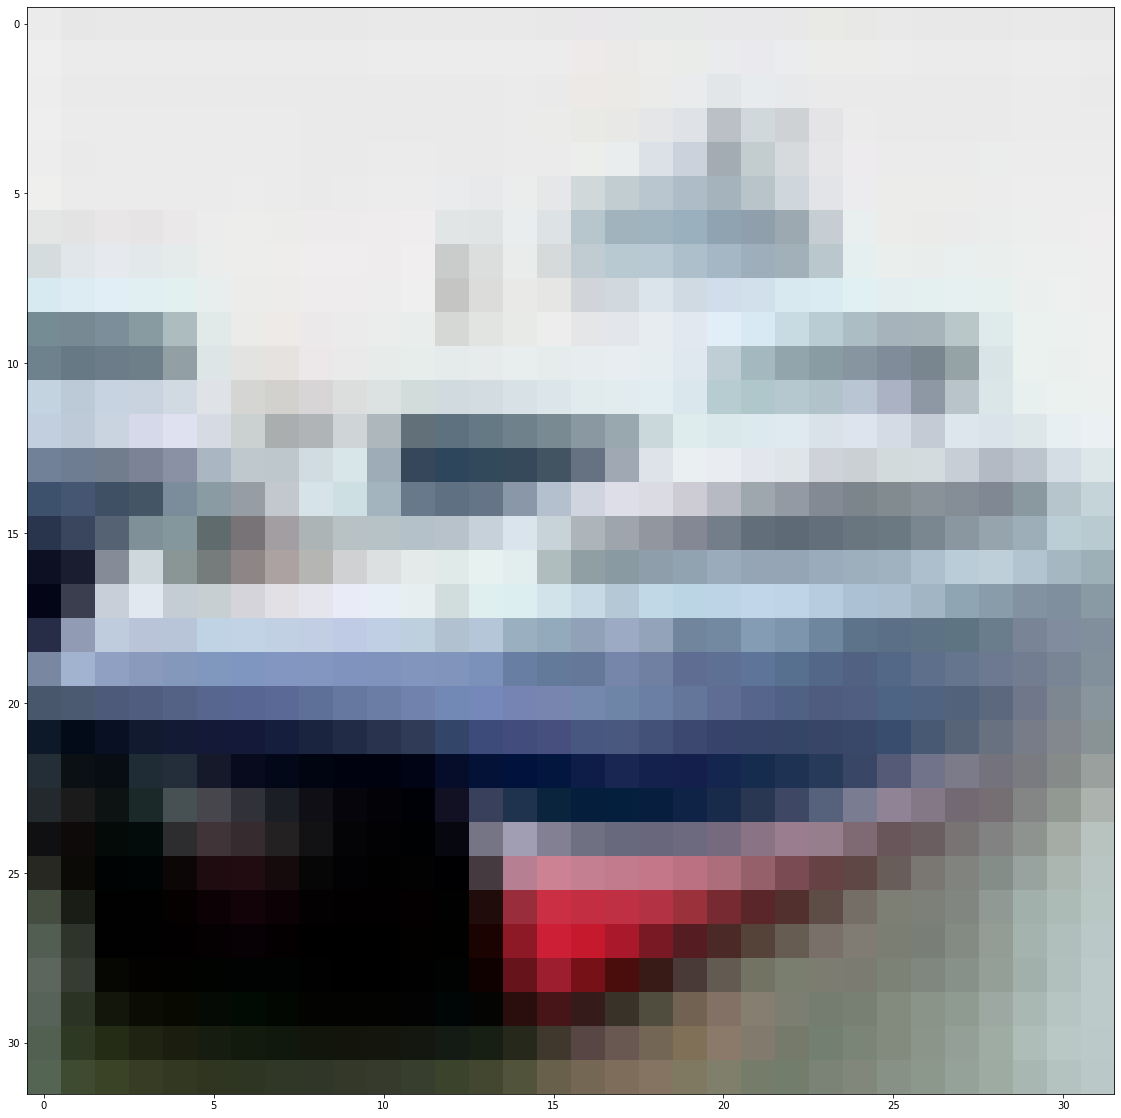

ship


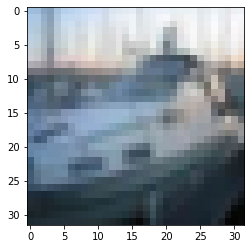

ship


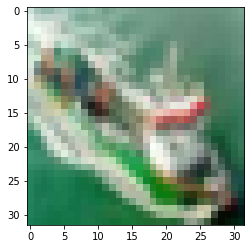

ship


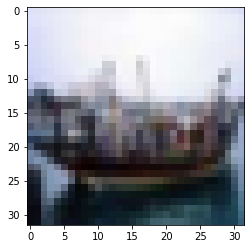

ship


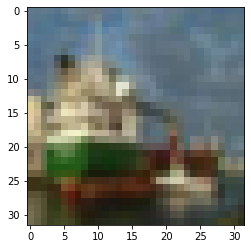

ship


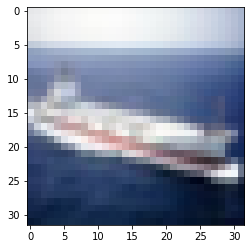

ship


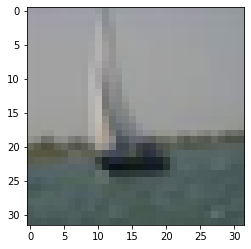

ship


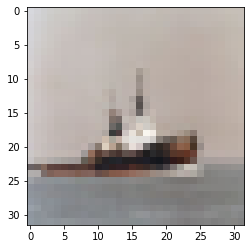

ship


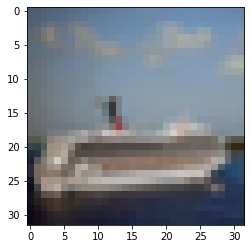

ship


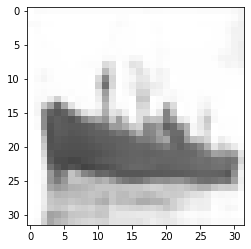

ship


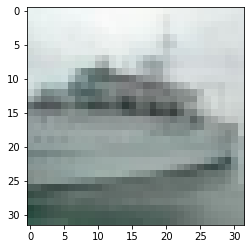

ship


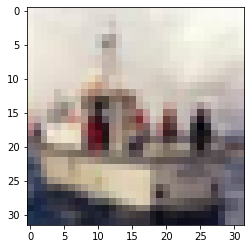

ship


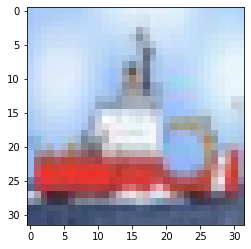

ship


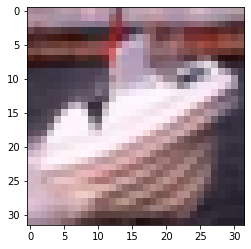

ship


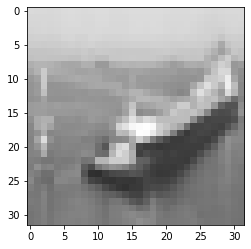

ship


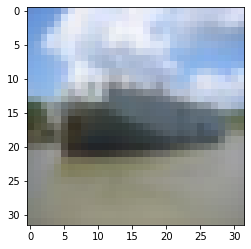

ship


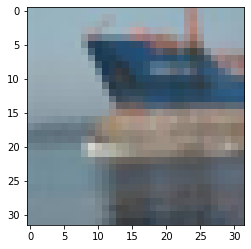

ship


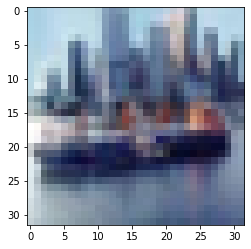

ship


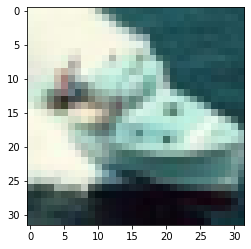

ship


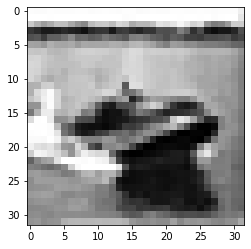

ship


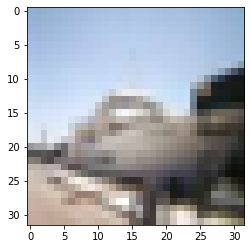

ship


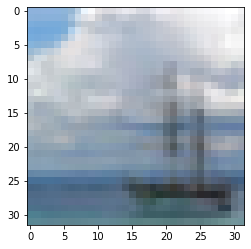

ship


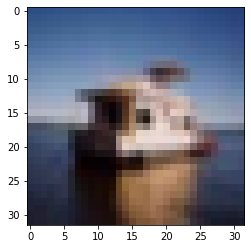

ship


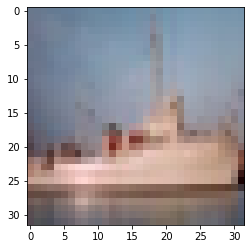

ship


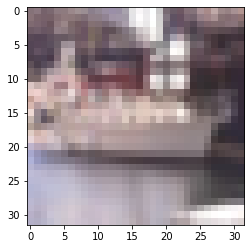

ship


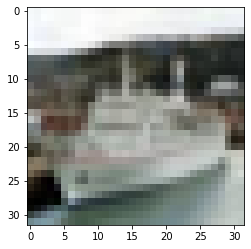

ship


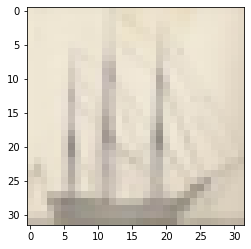

ship


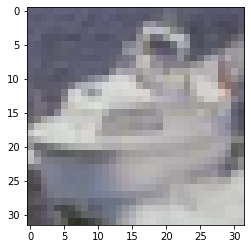

ship


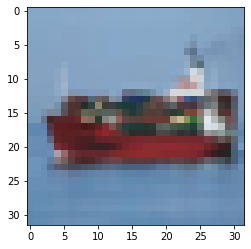

ship


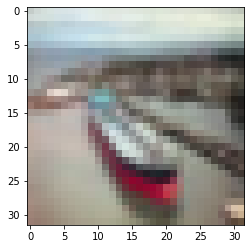

ship


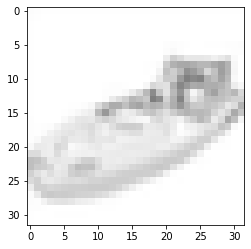

ship


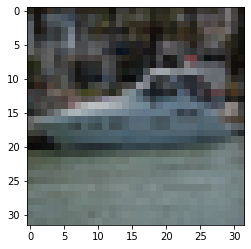

ship


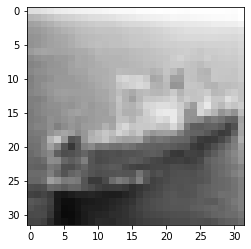

ship


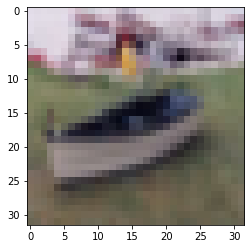

ship


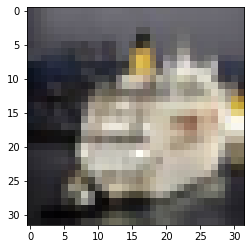

ship


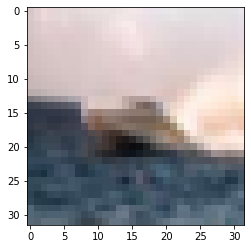

ship


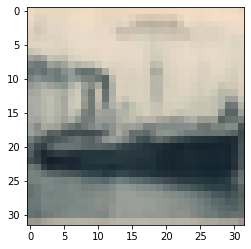

ship


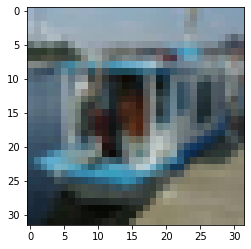

ship


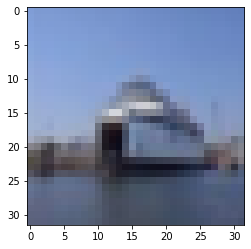

ship


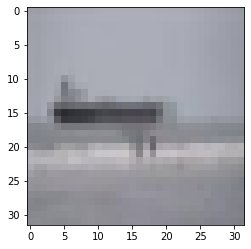

ship


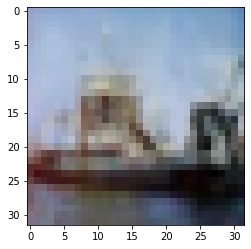

ship


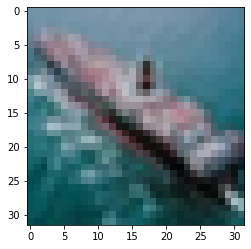

ship


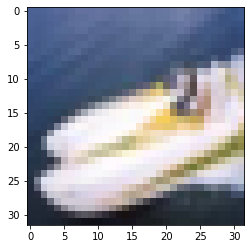

ship


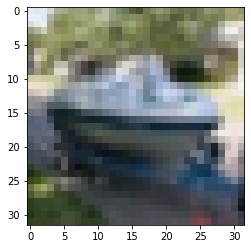

ship


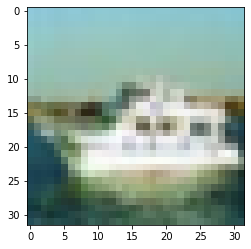

ship


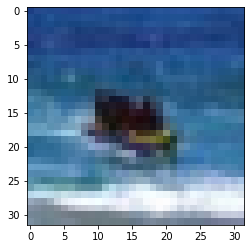

ship


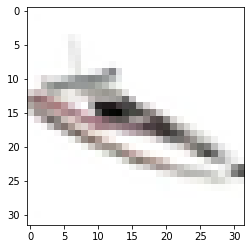

ship


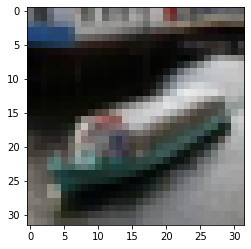

ship


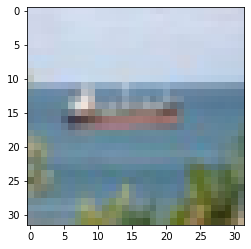

ship


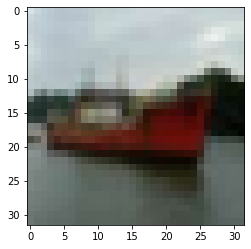

ship


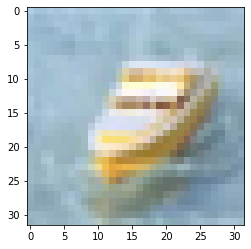

ship


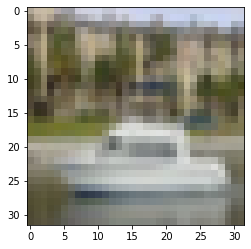

ship


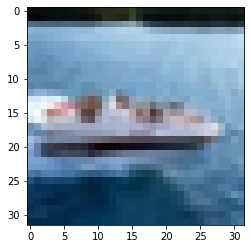

ship


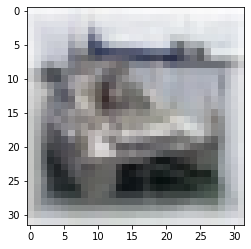

ship


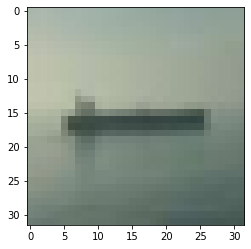

ship


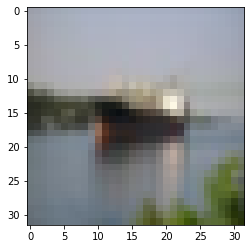

ship


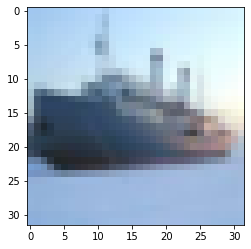

ship


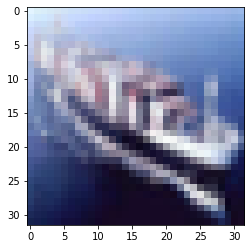

ship


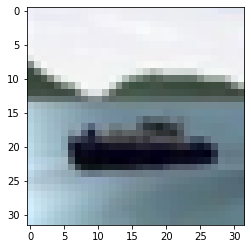

ship


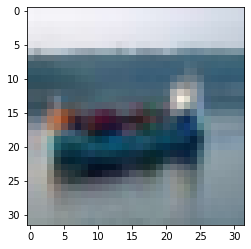

ship


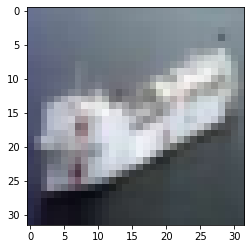

ship


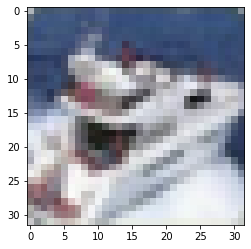

ship


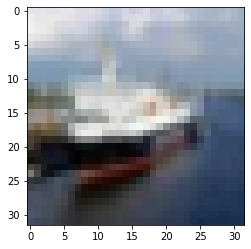

ship


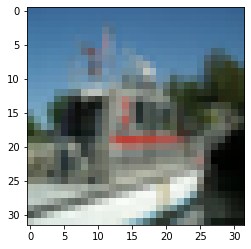

ship


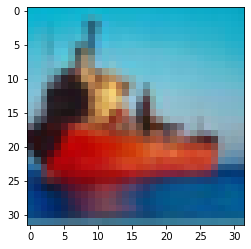

ship


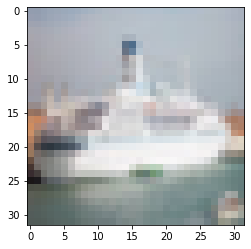

ship


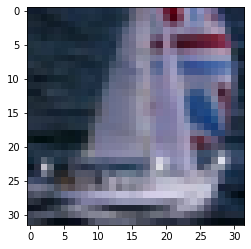

ship


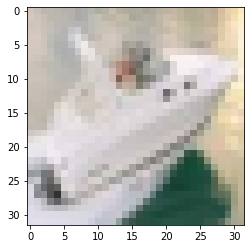

ship


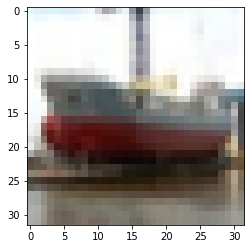

ship


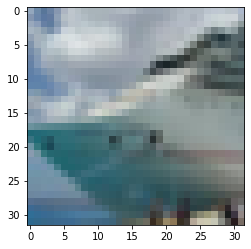

ship


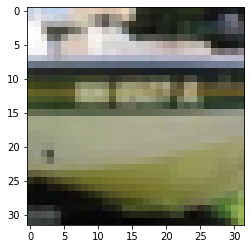

ship


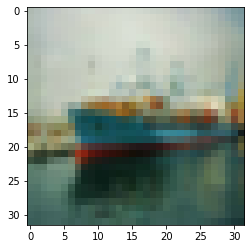

ship


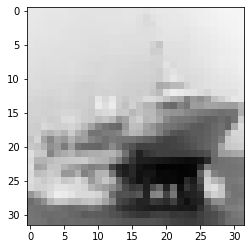

ship


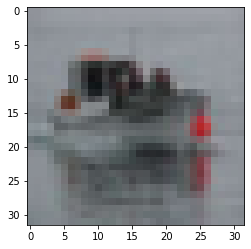

ship


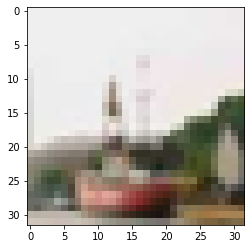

ship


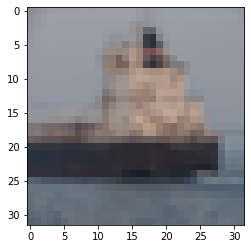

ship


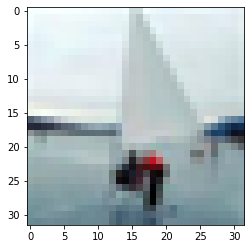

ship


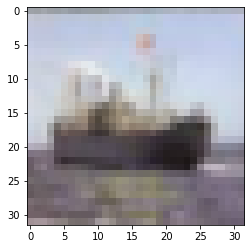

ship


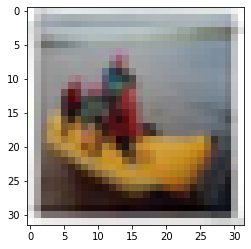

ship


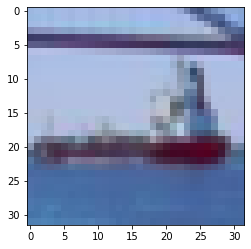

ship


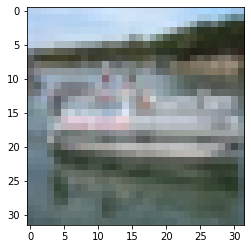

ship


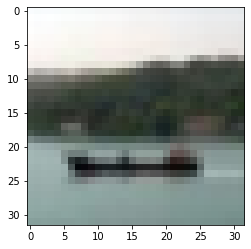

ship


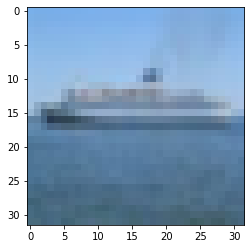

ship


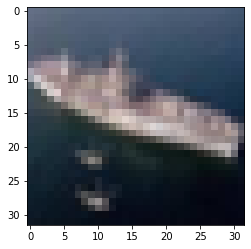

ship


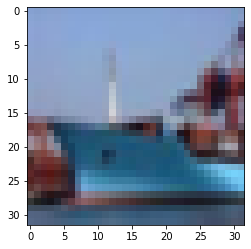

ship


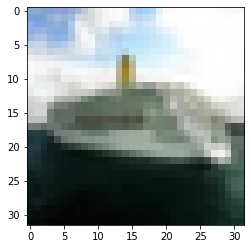

ship


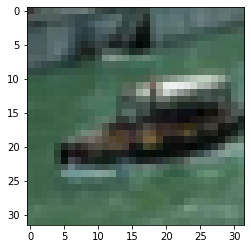

ship


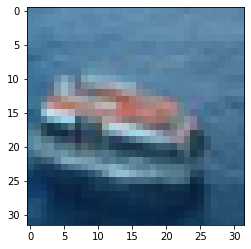

ship


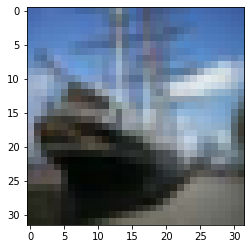

ship


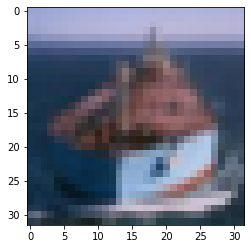

ship


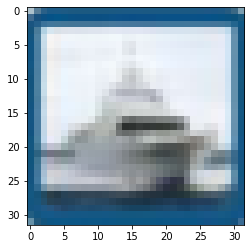

ship


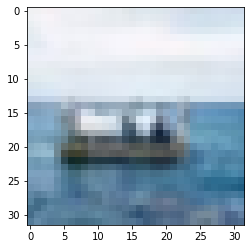

ship


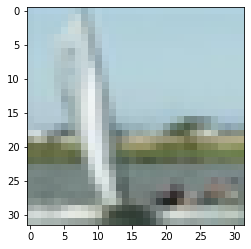

ship


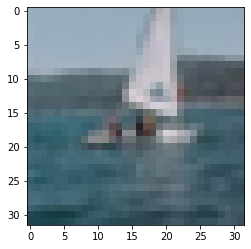

ship


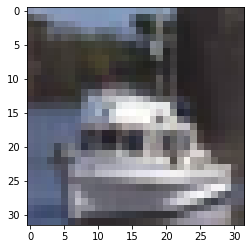

ship


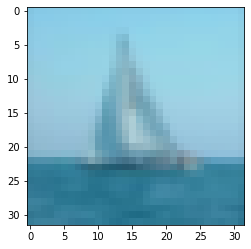

ship


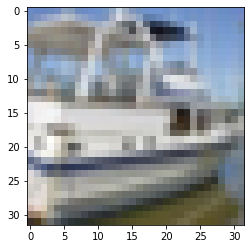

ship


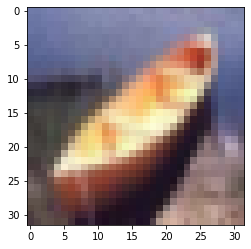

ship


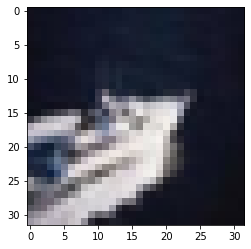

ship


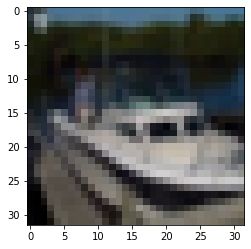

ship


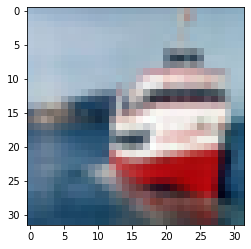

ship


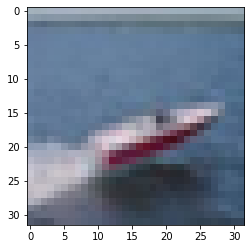

ship


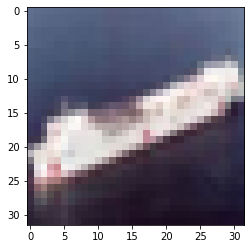

ship


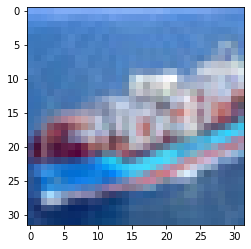

ship


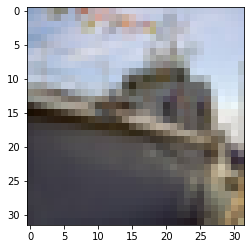

ship


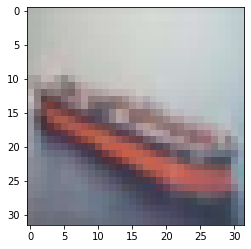

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(20,20))
test_label_arr = []
test_image_arr = []
x = 0
for i in range(1000):
    if test_labels[i] == 8:
        print('ship')
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        plt.show()
        test_label_arr.append(test_labels[i])
        test_image_arr.append(test_images[i])

In [4]:
test_label_arr[1]

array([8], dtype=uint8)

ship


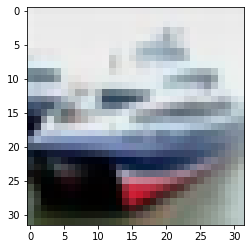

ship


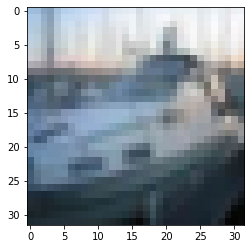

ship


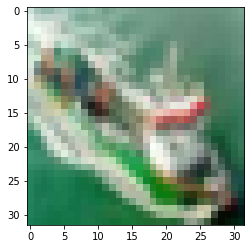

ship


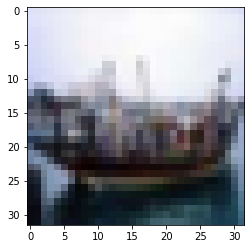

ship


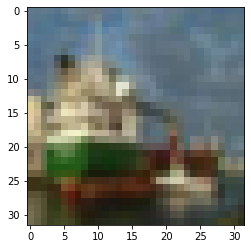

ship


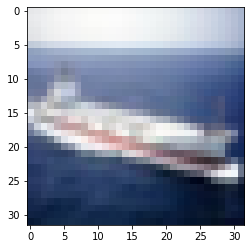

ship


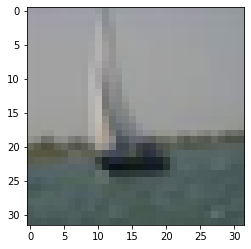

ship


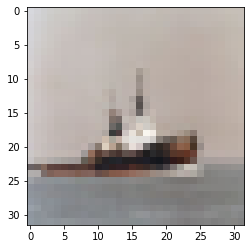

ship


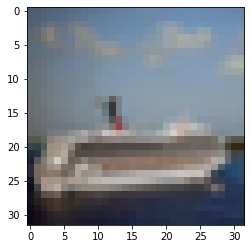

ship


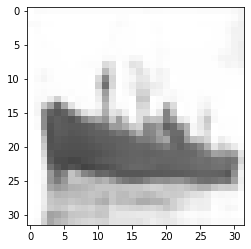

ship


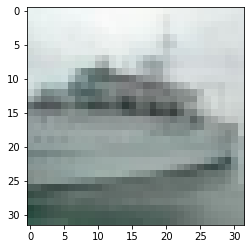

ship


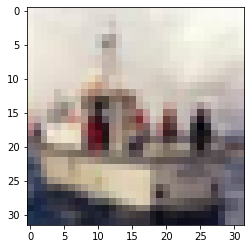

ship


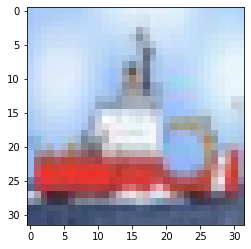

ship


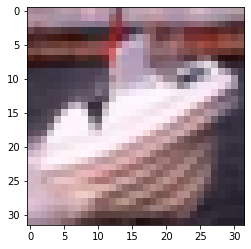

ship


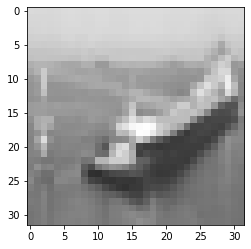

ship


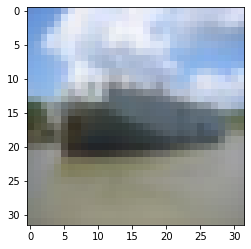

ship


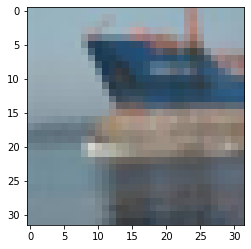

ship


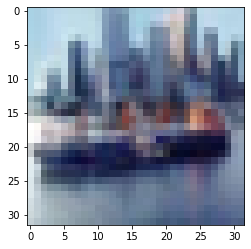

ship


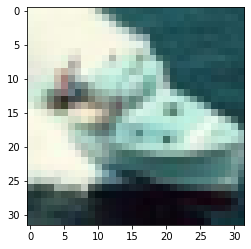

ship


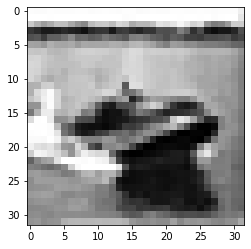

ship


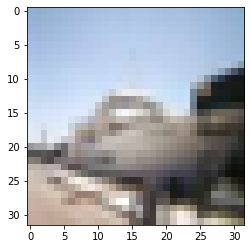

ship


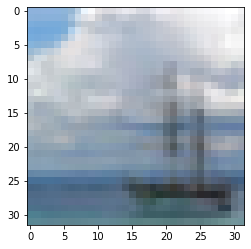

ship


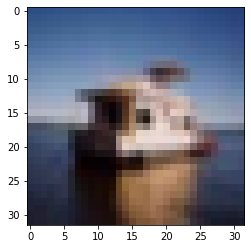

ship


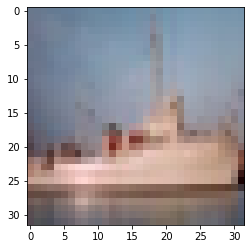

ship


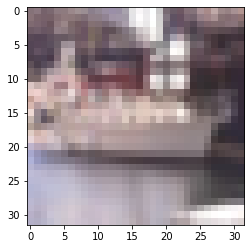

ship


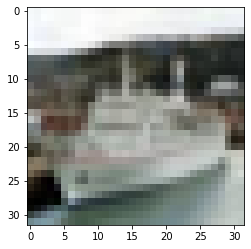

ship


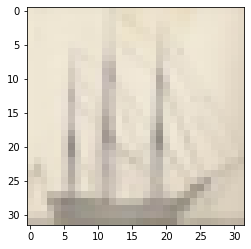

ship


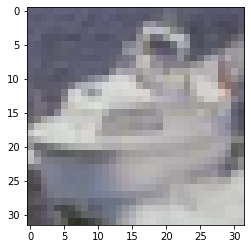

ship


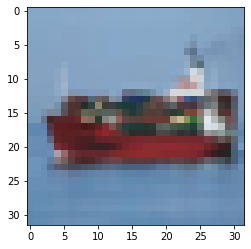

ship


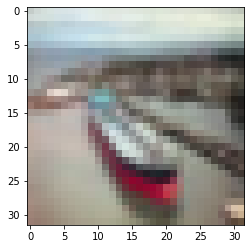

ship


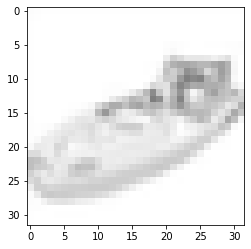

ship


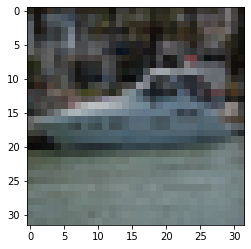

ship


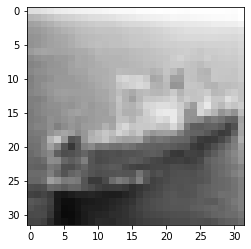

ship


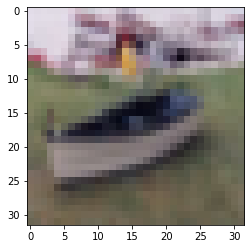

ship


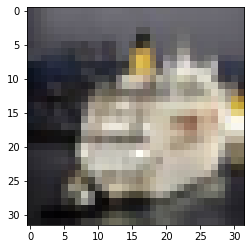

ship


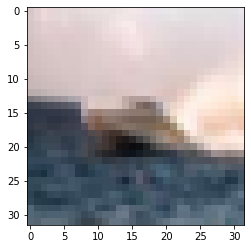

ship


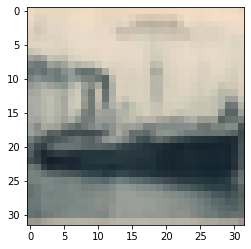

ship


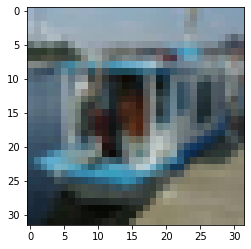

ship


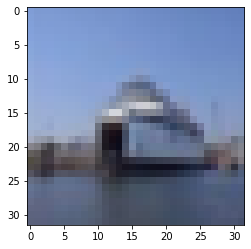

ship


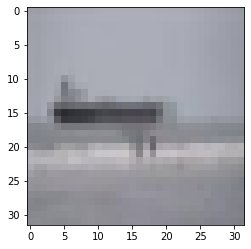

ship


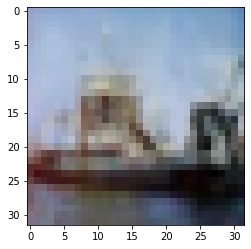

ship


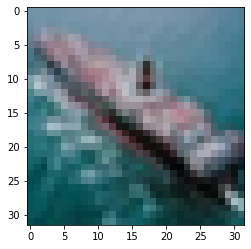

ship


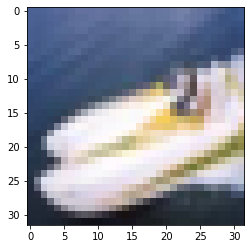

ship


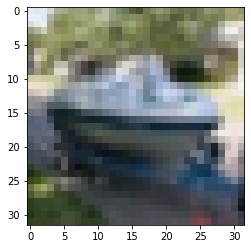

ship


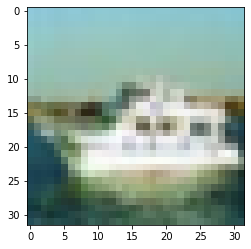

ship


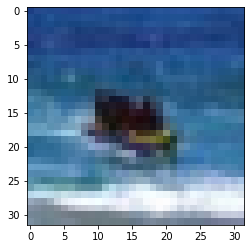

ship


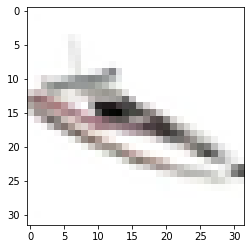

ship


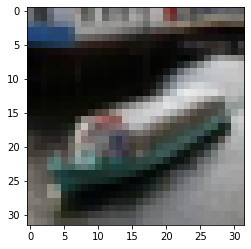

ship


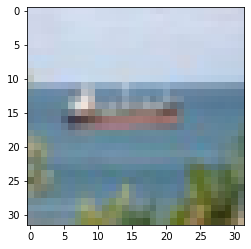

ship


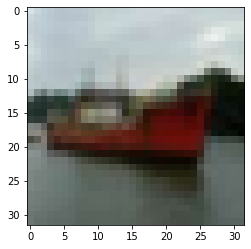

ship


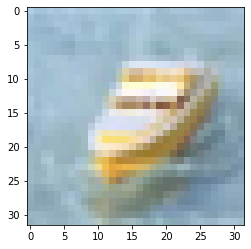

ship


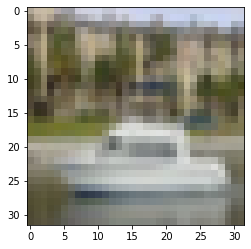

ship


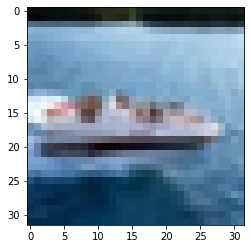

ship


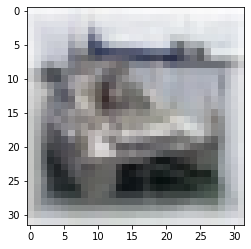

ship


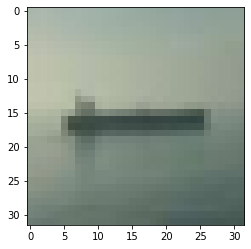

ship


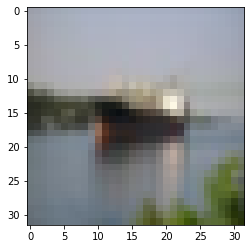

ship


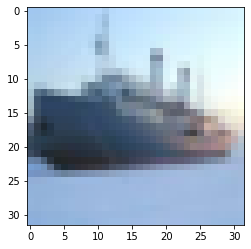

ship


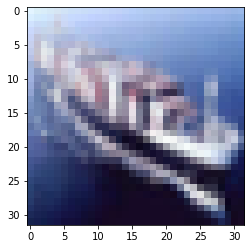

ship


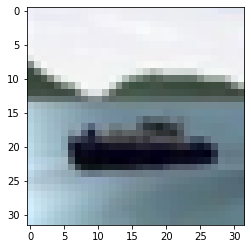

ship


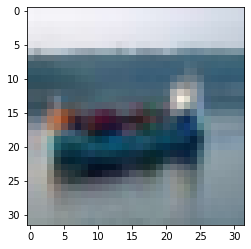

ship


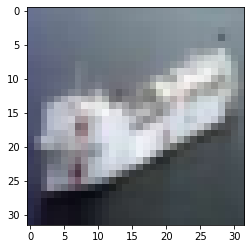

ship


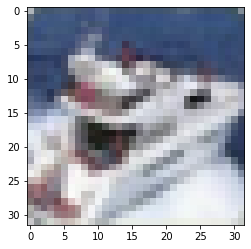

ship


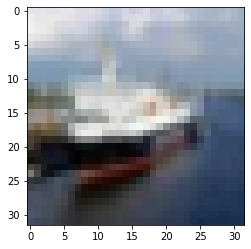

ship


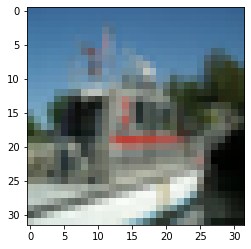

ship


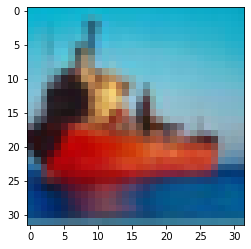

ship


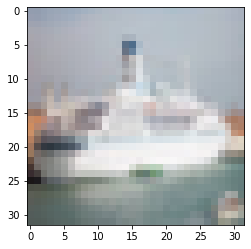

ship


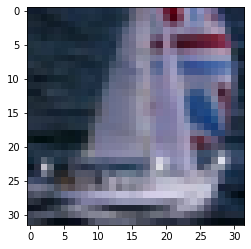

ship


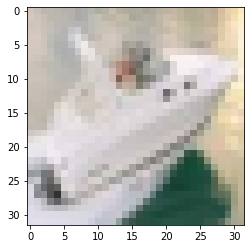

ship


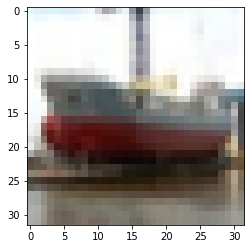

ship


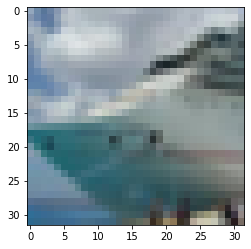

ship


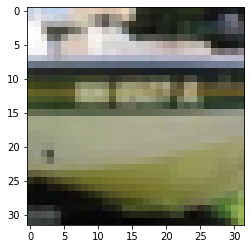

ship


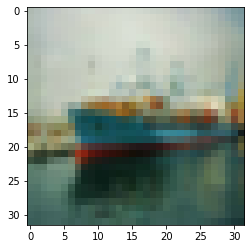

ship


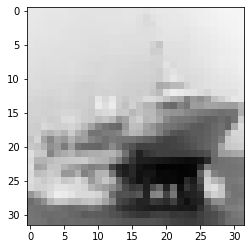

ship


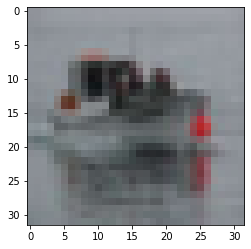

ship


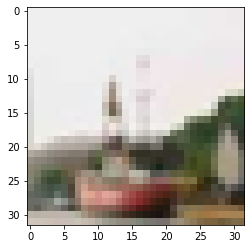

ship


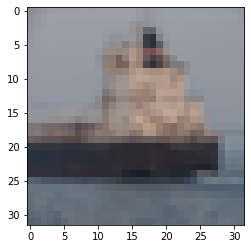

ship


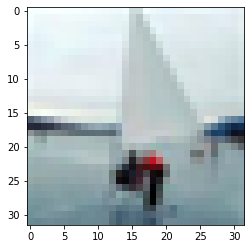

ship


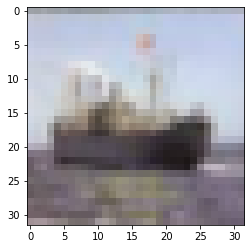

ship


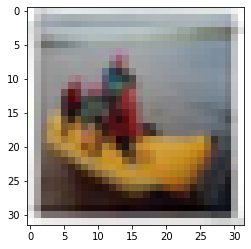

ship


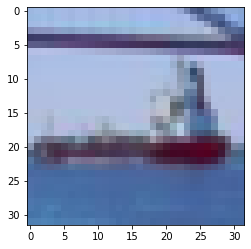

ship


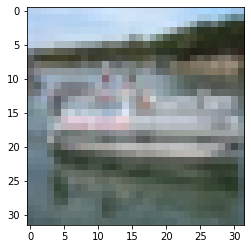

ship


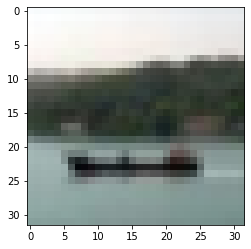

ship


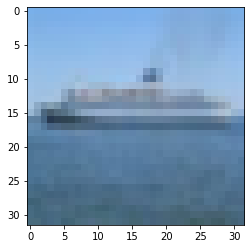

ship


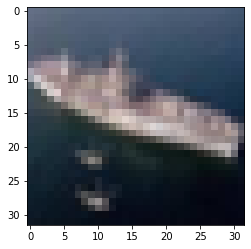

ship


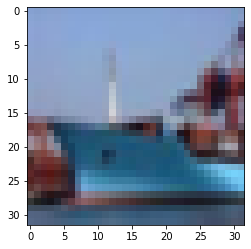

ship


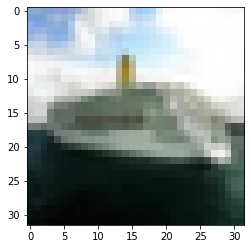

ship


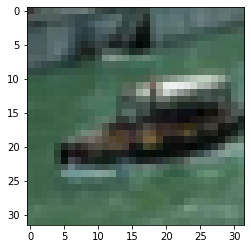

ship


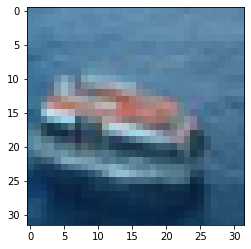

ship


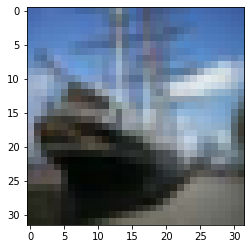

ship


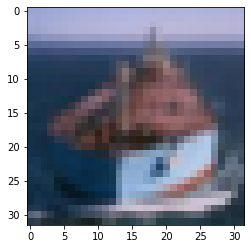

ship


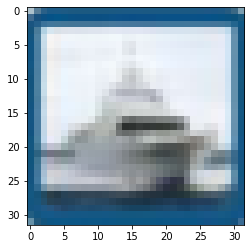

ship


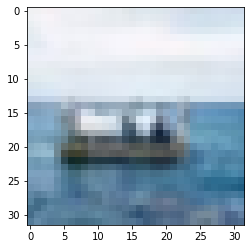

ship


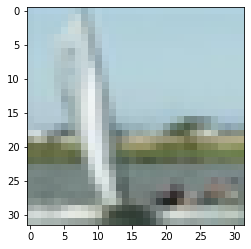

ship


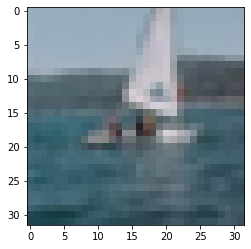

ship


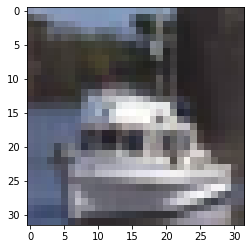

ship


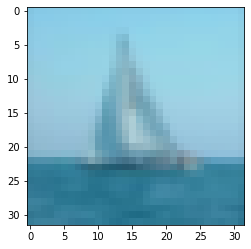

ship


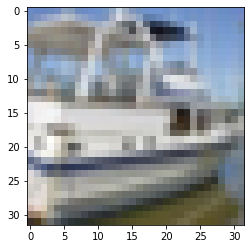

ship


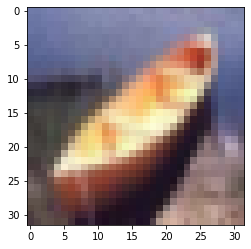

ship


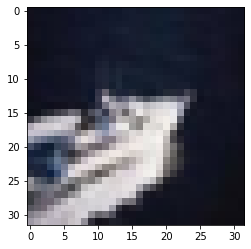

ship


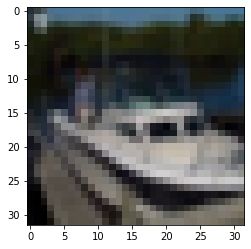

ship


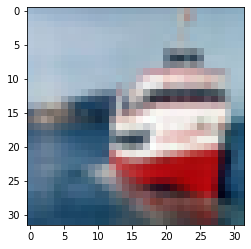

ship


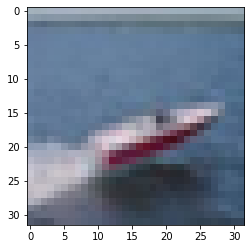

ship


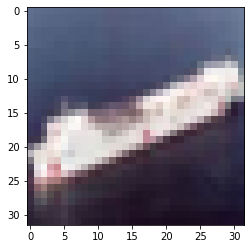

ship


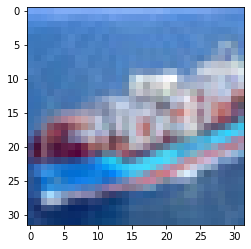

ship


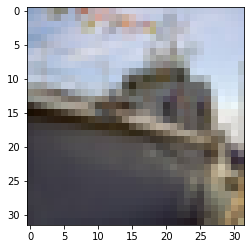

ship


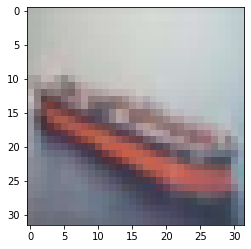

In [5]:
loop = len(test_image_arr)
for i in range(loop):
        print('ship')
        plt.imshow(test_image_arr[i], cmap=plt.cm.binary)
        plt.show()

An important factor in using Mark-Rcnn is that the it uses object segmentation. So within the image the object has to annotated.

In [6]:
coco_ships = pd.read_json('Ship_detection_maskrcnn_test.json')

In [7]:
coco_ships = coco_ships.transpose()
coco_ships = coco_ships[['filename','regions']]
coco_ships

filename                                            regions
im_1.jpg74701   im_1.jpg  [{'shape_attributes': {'name': 'rect', 'x': 16...
im_2.jpg178131  im_2.jpg  [{'shape_attributes': {'name': 'rect', 'x': 0,...
im_3.jpg10406   im_3.jpg  [{'shape_attributes': {'name': 'rect', 'x': 11...

In [8]:
data_list = []
for row in range(coco_ships.shape[0]):
    data_ships = coco_ships['regions'][row][0]['shape_attributes']
    print(data_ships)
    data_list.append(data_ships)
ship_annotdata = pd.DataFrame(data_list)
ship_annotdata = ship_annotdata[['x','y', 'width','height']]
ship_annotdata

{'name': 'rect', 'x': 162, 'y': 89, 'width': 641, 'height': 393}
{'name': 'rect', 'x': 0, 'y': 156, 'width': 1439, 'height': 524}
{'name': 'rect', 'x': 11, 'y': 36, 'width': 251, 'height': 121}


x    y  width  height
0  162   89    641     393
1    0  156   1439     524
2   11   36    251     121

In [9]:
coco_ships

filename                                            regions
im_1.jpg74701   im_1.jpg  [{'shape_attributes': {'name': 'rect', 'x': 16...
im_2.jpg178131  im_2.jpg  [{'shape_attributes': {'name': 'rect', 'x': 0,...
im_3.jpg10406   im_3.jpg  [{'shape_attributes': {'name': 'rect', 'x': 11...

## Cifar10 Conclusion 
What i quickly realised is that it would be hard to make a dataset that correctly fits the requirments for MASK-Rcnn as it is more foccused on segmentation within an image. For this reason i will find 10 train and 5 test images of ships and train it with this. And we will validate ourselves with 2 images.
<br>
To label the images i used the following website, which allows you to downlaod the annotation data according to the COCO guidelines. used tool to annotate images (http://www.robots.ox.ac.uk/~vgg/software/via/via_demo.html)

# 3) Configurate training/inference  and loading data

Creating a config parameters when training the model

In [10]:
# This class does not appoint all hyperparameters, since the default is what already worked on the COCO dataset
class ShipButtsConfig(Config):
    # Give the configuration a recognizable name
    NAME = "ships"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 4 + 1  # background + 1 (cig_butt)

    # It is generally seen as a smart move to configurate this to the amount of training images
    STEPS_PER_EPOCH = 40

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'
    
config = ShipButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

Necesarry functions to load data correctly

In [11]:
class CocoLikeDataset(Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                print(annotations[image_id])
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [12]:
# Creating a training and a validation(test) dataset.
dataset_train = CocoLikeDataset()
dataset_train.load_data('Ships_coco1.json', 'Ships_img')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('valdt.json', 'Ships_im_val')
dataset_val.prepare()

[{'segmentation': [[160, 95, 802, 95, 802, 484, 160, 484]], 'area': 249738, 'bbox': [160, 95, 642, 389], 'iscrowd': 0, 'id': 1, 'image_id': 1, 'category_id': 4}]
[{'segmentation': [[1, 155, 1438, 155, 1438, 678, 1, 678]], 'area': 751551, 'bbox': [1, 155, 1437, 523], 'iscrowd': 0, 'id': 2, 'image_id': 2, 'category_id': 4}]
[{'segmentation': [[10, 37, 260, 37, 260, 162, 10, 162]], 'area': 31250, 'bbox': [10, 37, 250, 125], 'iscrowd': 0, 'id': 3, 'image_id': 3, 'category_id': 4}]
[{'segmentation': [[155, 191, 1040, 191, 1040, 585, 155, 585]], 'area': 348690, 'bbox': [155, 191, 885, 394], 'iscrowd': 0, 'id': 4, 'image_id': 4, 'category_id': 4}]
[{'segmentation': [[85, 111, 1066, 111, 1066, 698, 85, 698]], 'area': 575847, 'bbox': [85, 111, 981, 587], 'iscrowd': 0, 'id': 5, 'image_id': 5, 'category_id': 4}]
[{'segmentation': [[94, 148, 1030, 148, 1030, 779, 94, 779]], 'area': 590616, 'bbox': [94, 148, 936, 631], 'iscrowd': 0, 'id': 6, 'image_id': 6, 'category_id': 4}]
[{'segmentation': [[0, 

Display what the model sees when it is presented with the image and how it should distinguish the background from the annotations.

[11 14 30  8  8  4 34 10 20 33]


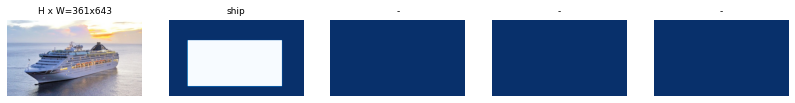

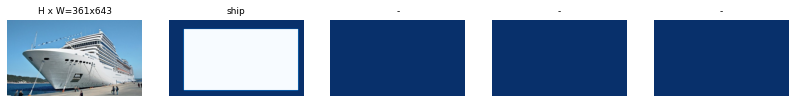

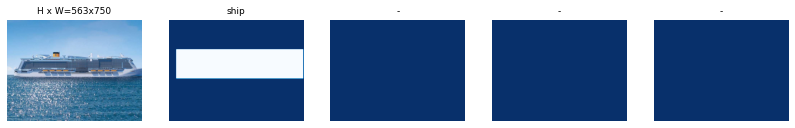

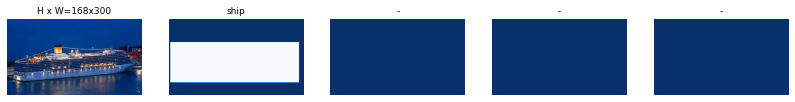

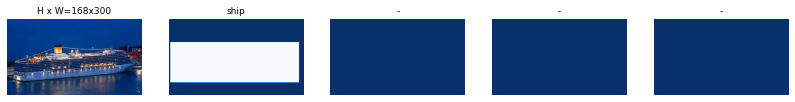

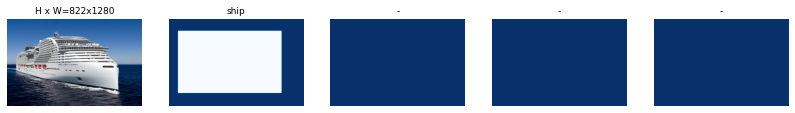

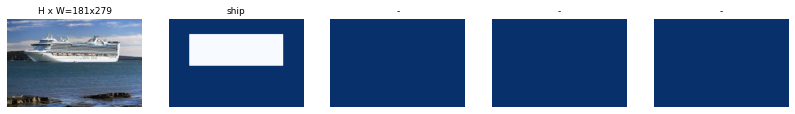

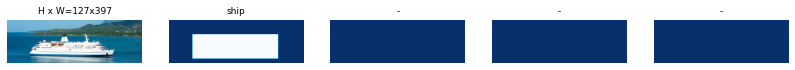

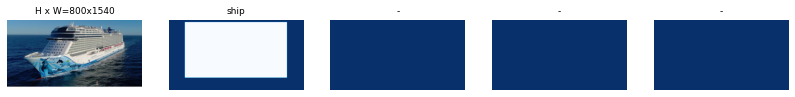

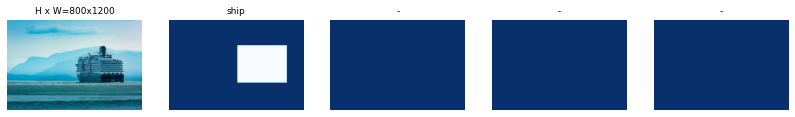

In [13]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 10)
print(image_ids)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

Creating and trainign the model. Keep in mind i did not create a larger dataset since it took an hour of training for 100 eppchs (even with my GPU). Keep in mind we did not load the previouse weights and this model is only abel to predict ships.

In [14]:
# Create model in training mode
model = MaskRCNN(mode="training", config=config,
                          model_dir='C:/Users/Max_PC/Desktop/Minor 2.0/Minor-Max-de-Goede/CNN')

In [15]:
start_train = time.time()
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE, 
#            epochs=100, 
#            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

Training took 0.0 minutes


Creating the inference instance, this allows us to load a model and then use it. Lets see the results!

In [16]:
class InferenceConfig(ShipButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [17]:
# Create model in inference mode.
model = MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='C:/Users/Max_PC/Desktop/Minor 2.0/Minor-Max-de-Goede/CNN/')

Instructions for updating:
Use fn_output_signature instead


In [18]:
# Load trained weights (fill in path to trained weights here)
print("Loading weights from ", 'mask_rcnn_ships_0100.h5')
model.load_weights('mask_rcnn_ships_0100.h5', by_name=True)

Loading weights from  mask_rcnn_ships_0100.h5


## We will try the network out on images it has not seen before

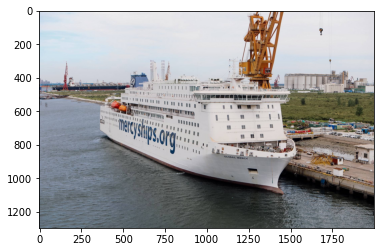

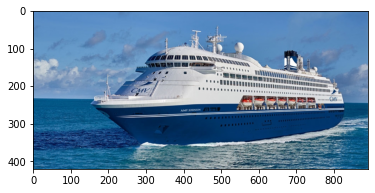

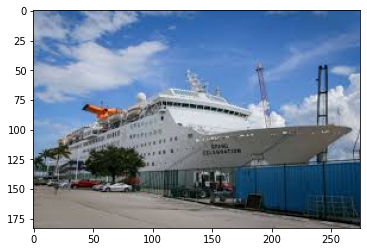

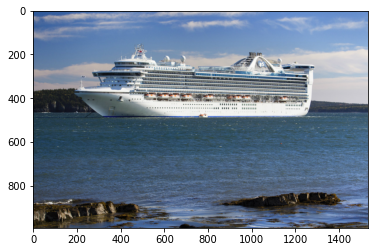

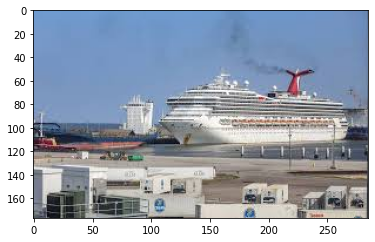

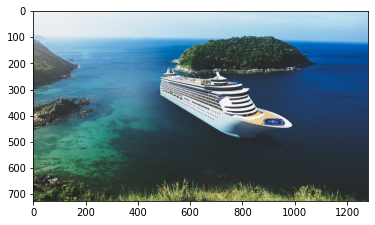

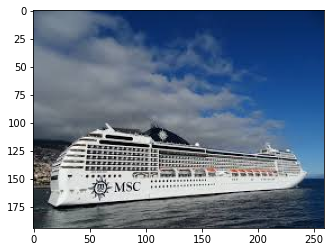

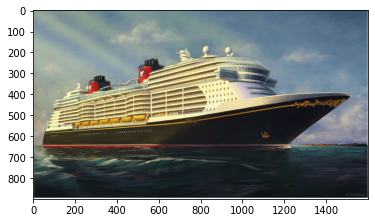

In [23]:
# Displaying the images that the network has not yet seen
def plotim(img):
    img = mpimg.imread(img)
    imgplot = plt.imshow(img)
    plt.show()
plotim('test_img.jpg')
plotim('test_img2.jpg')
plotim('test_img3.jpg')
plotim('test_img4.jpg')
plotim('test_img5.jpg')
plotim('test_img6.jpg')
plotim('test_img7.jpg')
plotim('test_img8.jpg')

Processing 1 images
image                    shape: (1297, 2000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 2000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



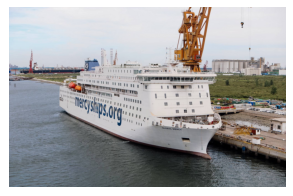

Processing 1 images
image                    shape: (420, 891, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


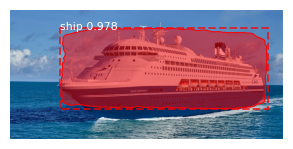

Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


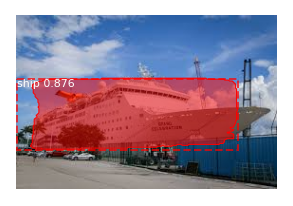

Processing 1 images
image                    shape: (994, 1532, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1532.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


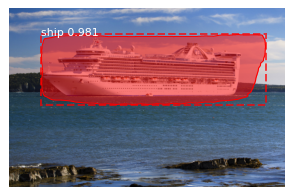

Processing 1 images
image                    shape: (177, 285, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



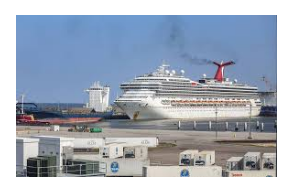

Processing 1 images
image                    shape: (726, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


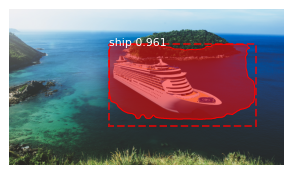

Processing 1 images
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



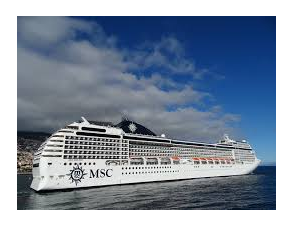

Processing 1 images
image                    shape: (900, 1600, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



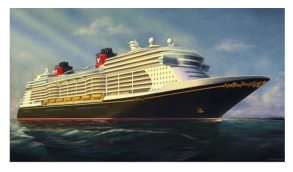

In [21]:
import skimage
def scoreoverview(img):
    img = skimage.io.imread(img)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    print(dataset_train.class_names)
    print(r['scores'])
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                    dataset_train.class_names,r['scores'], figsize=(5,5))
scoreoverview('test_img.jpg')
scoreoverview('test_img2.jpg')
scoreoverview('test_img3.jpg')
scoreoverview('test_img4.jpg')
scoreoverview('test_img5.jpg')
scoreoverview('test_img6.jpg')
scoreoverview('test_img7.jpg')
scoreoverview('test_img8.jpg')

## Conclusion
Well, by using 40 images we can conclcude that it is indeed actually possible to detect images. For me i see this as a success. Because if i would really want to and would be motivated too. To conclude this all i need to do is increase the number of the Train/Test data so we could get better results.
<br>
<br>
I played with hyper parameters such as the epoch and realized that the diffrences between the number of epoch actually had quite a big impact i will display the difference in results below

Model with 3 epochs and 3 training images, we see in the image below that the model is randomly annotation with very high confidence (kind of funny)

In [ ]:
model = MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='C:/Users/Max_PC/Desktop/Minor 2.0/Minor-Max-de-Goede/CNN/')
model.load_weights('Previouse versions/mask_rcnn_ships_3_train_images.h5', by_name=True)
img = skimage.io.imread('test_img2.jpg')
img_arr = np.array(img)
results = model.detect([img_arr], verbose=1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names,r['scores'], figsize=(5,5))

Model with 10 epoch and 40 training images, we see that this i much better than above,it looks like the model is somewhat detecting what a ship looks like!

In [ ]:
model.load_weights('Previouse versions/mask_rcnn_ships_40_img_10epoch.h5', by_name=True)
img = skimage.io.imread('test_img2.jpg')
img_arr = np.array(img)
results = model.detect([img_arr], verbose=1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names,r['scores'], figsize=(5,5))

## Code bellow is from my previouse endevor when i could not get the data labbled correctly

# Problem and what do we do from here?
I had a few problems with this exercise i will name them here:
<br>
<br>
1. I could not use my GPU to train with MASK-Rcnn as it has not been updated for since tensorflow 1.3.0. And thus i had to use a separate enviroment (which is not compatible with cuda version 10.1). It took me 5 hours to train with the dataset that was givem.
<br>
2. Sadly i could not get my dataset to work. I my own data import function, but it did not work (I did not just want to copy what a tutorial said). Even though i am using the correct annotations for a COCO dataset (Which is the dataset which MaskRcnn has pretrained weights for). I will look furhter into this as i would really like have notebook where i did all of this and am somewhat able to detect ships. (maybe it doenst help that i am trying to import the anotations with a json file as opposed to what the tutorial told me to. 
<br>
<br>


## Temporary Solution
<br>
For the time being i ran the code from the tutorial in a separate notebook and will show the results of the trained model there. I will update this notebook later on where i am able to correctly import and label the images using a json file.
<br>
The code that you will see there is a mere copy paste, just so the idea can be made clear of how i wanted to use transfer learning for my own usage. I will fix the images coming weekend.